# Calculation of linear spectra for molecular aggregate

In [1]:
from quantarhei import Molecule, Aggregate
from quantarhei import energy_units, convert
from quantarhei import CorrelationFunction, TimeAxis
from quantarhei.spectroscopy.abscalculator import LinSpectrumCalculator
import numpy as np

create aggregate from two molecules

In [2]:
# define molecules
with energy_units("1/cm"):
    # first molecule - two level molecule
    mol1 = Molecule(name="Molecule 1",elenergies=[0,[16000,18000]])  # excitation energies in 1/cm
    mol1.set_dipole(0,1,[2.0 , 0.0, 0.0])  # 0->1 transition dipole in Debye
    mol1.set_dipole(0,2,[1.0 , 0.0, 0.0])  # 0->2 transition dipole in Debye
    # for the rest of the transitions assume zero dipole moment
    mol1._position = np.array([0.0,0.0,0.0],dtype="f8")   # center of the molecule in Angstroms
    
    # second molecule - one level molecule
    mol2 = Molecule(name="Molecule 2",elenergies=[0,16200])  # excitation energies in 1/cm
    mol2.set_dipole(0,1,[2.0/np.sqrt(2.0) , 2.0/np.sqrt(2.0), 0.0])  # 0->1 transition dipole in Debye
    # for the rest of the transitions assume zero dipole moment
    mol2._position = np.array([4.0,0.0,1.0],dtype="f8")   # center of the molecule in Angstroms
    
# define system bath interaction
time = TimeAxis(0.0, 4000, 0.5)
with energy_units("1/cm"):
    cfce_params = dict(ftype="OverdampedBrownian",
                   reorg=150.0,        # Reorganization energy in cm-1
                   cortime=200.0,      # in fs
                   T=77,matsubara=40)  # temperature = 77K 
    cfce = CorrelationFunction(time,cfce_params)
    
# Add correlation fucntion to the molecule - we use for both molecules the same correlation function
mol1.set_egcf((0,1),cfce)
mol1.set_egcf((0,2),cfce)
mol2.set_egcf((0,1),cfce)
    
# Create the aggregate
aggreg = Aggregate()
aggreg.add_Molecule(mol1)
aggreg.add_Molecule(mol2)

# Set dipole dipole interaction energy
aggreg.set_coupling_by_dipole_dipole_vec(epsr=1.0)

# set interaction element externaly
aggreg._set_coupling_vec(0,0,2,1,0,1,-0.02) # Set coupling between monomer[0] 0->2 transition and monomer[1] 0->1 transition to -0.002 int units

# Build the aggregate 
aggreg.build()

Print aggregate properties

In [3]:
print("Hamiltonian in internal units:")
print(aggreg.HH)
print("\nHamiltonian in 1/cm:")
with energy_units("1/cm"):
    print(np.round(aggreg.HamOp.data))

print("\nElectronic states:")
print(aggreg.elsigs)

print("\nRotatory strength")
print(aggreg.RRv)

Hamiltonian in internal units:
[[ 0.          0.          0.          0.        ]
 [ 0.          3.01384251 -0.06977635  0.        ]
 [ 0.         -0.06977635  3.05151554 -0.02      ]
 [ 0.          0.         -0.02        3.39057282]]

Hamiltonian in 1/cm:
[[     0.      0.      0.      0.]
 [     0.  16000.   -370.      0.]
 [     0.   -370.  16200.   -106.]
 [     0.      0.   -106.  18000.]]

Electronic states:
[(0, 0), (1, 0), (0, 1), (2, 0)]

Rotatory strength
[[ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.         -8.63098932  0.         -4.31549466]
 [ 0.          0.          0.          0.        ]]


Calculate linear spectra

In [4]:
acalc = LinSpectrumCalculator(time,system=aggreg)
with energy_units("1/cm"):
    rwa_cm = aggreg.get_RWA_suggestion()
    print("Suggested RWA freq:",rwa_cm,"cm-1")
    acalc.bootstrap(rwa=rwa_cm,HWHH=100.0) # If HWHH specified also spectra with gaussian peak is calculated
spectra = acalc.calculate()

Suggested RWA freq: 16733.3333333 cm-1


Plot spectra

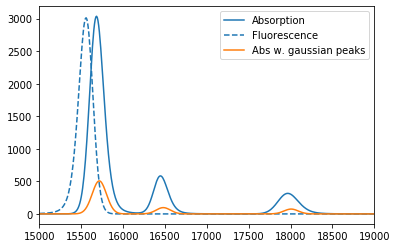

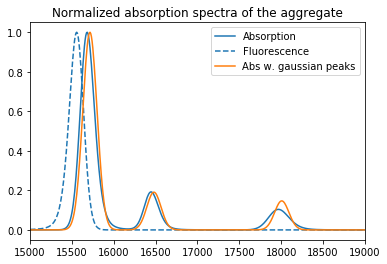

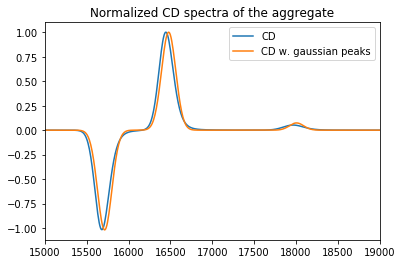

In [5]:
from matplotlib import pyplot as plt

# plot absorption spectra 
with energy_units("1/cm"):
    plt.figure()
    plt.plot(spectra["abs"].axis.data,spectra["abs"].data,"C0-")
    plt.plot(spectra["fluor"].axis.data,spectra["fluor"].data,"C0--")
    plt.plot(spectra["abs gauss"].axis.data,spectra["abs gauss"].data,"C1-")
    plt.legend(["Absorption","Fluorescence","Abs w. gaussian peaks"])
    plt.xlim([15000,19000])
    
# plot normalized absorption spectra
with energy_units("1/cm"):
    plt.figure()
    plt.title("Normalized absorption spectra of the aggregate")
    plt.plot(spectra["abs"].axis.data,spectra["abs"].data/np.max(spectra["abs"].data),"C0-")
    plt.plot(spectra["fluor"].axis.data,spectra["fluor"].data/np.max(spectra["fluor"].data),"C0--")
    plt.plot(spectra["abs gauss"].axis.data,spectra["abs gauss"].data/np.max(spectra["abs gauss"].data),"C1")
    plt.legend(["Absorption","Fluorescence","Abs w. gaussian peaks"])
    plt.xlim([15000,19000])

# plot normalized CD spectra
with energy_units("1/cm"):
    plt.figure()
    plt.title("Normalized CD spectra of the aggregate")
    plt.plot(spectra["CD"].axis.data,spectra["CD"].data/np.max(spectra["CD"].data))
    plt.plot(spectra["CD gauss"].axis.data,spectra["CD gauss"].data/np.max(spectra["CD gauss"].data))
    plt.legend(["CD","CD w. gaussian peaks"])
    plt.xlim([15000,19000])

# Vibronic aggregate

In [6]:
from quantarhei import Mode

# Define molecule
with energy_units("1/cm"):
    car = Molecule(name="Carotenoid",elenergies=[0.0,[17400,18900]])
    car.set_dipole(0,1,[0.0, 0.03, 0.0])  # 0->1 transition dipole in Debye (S0->S1)
    car.set_dipole(0,2,[1.28 , 0.0, 0.0]) # 0->2 transition dipole in Debye (S0->S2)
    
    # Add vibrational levels
    vib_mode1 = Mode(frequency = 1550.0) # Define normal mode frequency
    car.add_Mode(vib_mode1)              # Add normal mode to the molecule
    car.modes[0].set_shift(2,1.22)       # Define shift of the ground state and excited state potential surface
    car.modes[0].set_shift(1,0.0)        # reorgE = frequency*(shift^2)/2  ( HuangRhys fac. = (shift**2)/2.0 )
    vib_mode2 = Mode(frequency = 1150.0) # Define normal mode frequency
    car.add_Mode(vib_mode2)              # Add normal mode to the molecule
    car.modes[1].set_shift(2,1.0)        # Define shift of the ground state and excited state potential surface
    car.modes[1].set_shift(1,0.0)        # reorgE = frequency*(shift^2)/2  ( HuangRhys fac. = (shift**2)/2.0 )

    
# define system bath interaction
time = TimeAxis(0.0, 4000, 0.5)
with energy_units("1/cm"):
    cfce_params = dict(ftype="OverdampedBrownian",
                   reorg=700.0,        # Reorganization energy in cm-1
                   cortime=200.0,      # in fs
                   T=300,matsubara=40) # temperature = 300K 
    cfce_S2 = CorrelationFunction(time,cfce_params)
    
    cfce_params = dict(ftype="OverdampedBrownian",
                   reorg=600.0,        # Reorganization energy in cm-1
                   cortime=200.0,      # in fs
                   T=300,matsubara=40) # temperature = 300K 
    cfce_S1 = CorrelationFunction(time,cfce_params)
    
    car.set_egcf((0,1),cfce_S1)
    car.set_egcf((0,2),cfce_S2)

# Define parameters for vibronic aggregate
Nvib = 2
nmode = 2
vibenergy_cutoff=2.0
vibgen_approx="NPA"


# Construct aggregate composed of the single molecule
aggreg = Aggregate()
aggreg.add_Molecule(car)

# Build vibronic aggregate
aggreg.build(mult=2,sbi_for_higher_ex=True,
                 vibgen_approx=vibgen_approx, Nvib=Nvib,
                 vibenergy_cutoff=vibenergy_cutoff)

Calculate linear spectra

In [7]:
acalc = LinSpectrumCalculator(time,system=aggreg)
with energy_units("1/cm"):
    rwa_cm = aggreg.get_RWA_suggestion()
    print("Suggested RWA freq:",rwa_cm,"cm-1")
    acalc.bootstrap(rwa=rwa_cm,HWHH=100.0) # If HWHH specified also spectra with gaussian peak is calculated
spectra = acalc.calculate()

Suggested RWA freq: 18150.0 cm-1


In [8]:
# definition of the experimental spectra
import csv

# read experimental spectra
with open("exp_data/Carotenoid_exp_spec.csv", 'r') as f:
    reader = csv.reader(f)
    Abs_spec_nm = []
    Abs_spec_cm = []
    for row in reader:
        Abs_spec_nm.append([float(row[0]),float(row[1])])
        Abs_spec_cm.append([convert(float(row[0]),"nm","1/cm"),float(row[1])])
Abs_spec_nm = np.array(Abs_spec_nm,dtype='f8')
Abs_spec_cm = np.array(Abs_spec_cm,dtype='f8')

Plot the spectra

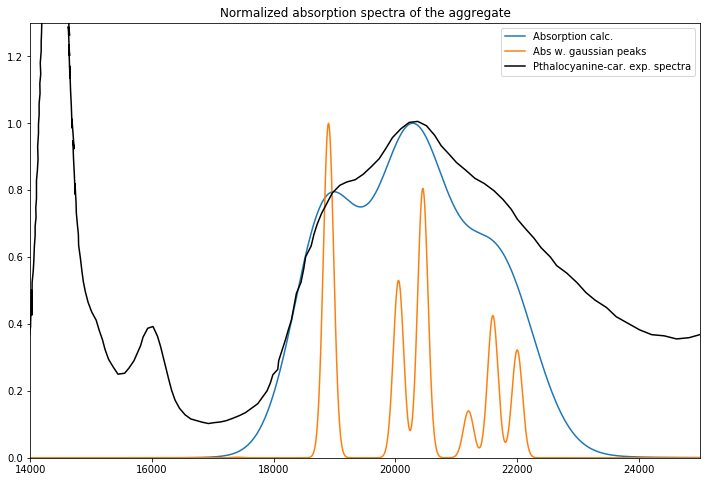

In [10]:
from matplotlib import pyplot as plt

# plot normalized absorption spectra
with energy_units("1/cm"):
    plt.figure(figsize=(12,8))
    plt.title("Normalized absorption spectra of the aggregate")
    plt.plot(spectra["abs"].axis.data,spectra["abs"].data/np.max(spectra["abs"].data),"C0-")
    #plt.plot(spectra["fluor"].axis.data,spectra["fluor"].data/np.max(spectra["fluor"].data),"C0--")
    plt.plot(spectra["abs gauss"].axis.data,spectra["abs gauss"].data/np.max(spectra["abs gauss"].data),"C1")
    
    # Normalize absorption spectra
    Abs_spec_cm[:,1]=Abs_spec_cm[:,1]/max(Abs_spec_cm[:,1])/0.4727
    plt.plot(Abs_spec_cm[:,0],Abs_spec_cm[:,1],'k') 
    
    plt.legend(["Absorption calc.","Abs w. gaussian peaks","Pthalocyanine-car. exp. spectra"])
    #plt.legend(["Absorption","Fluorescence","Abs w. gaussian peaks","Pthalocyanine-car. exp. spectra"])
    plt.xlim([14000,25000])
    plt.ylim([0.0,1.3])